## Identify Potential Housing Maintenance Code Violators in New York City

In [86]:
import dask.dataframe as dd
import geopandas as gpd
import h3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Polygon

from landlords.plotting import plot_vbar

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data



In this section, we import from the data sources publicly through [NYC Open Data](https://opendata.cityofnewyork.us). For this assessment, we devote our focus to the data sources below:

- All Housing, Preservation, and Development (HPD) data (available: http://on.nyc.gov/1YlIN2t) 
    - Registrations (also available via Socrata: http://bit.ly/1Uvviry) 
    - Registration Contacts (also available via Socrata: http://bit.ly/2rjoGJg) 
    - Violations (also available via Socrata: http://bit.ly/1Ue5dju) 
    - Pluto Building (available: http://on.nyc.gov/1RRCnGO)
    
The [NYC Open Data](https://opendata.cityofnewyork.us)'s catalog contains information for each dataset, including data dictionaries, which will leverage to inform our analysis. On data access, the datasets can be retrieved via multiple methods, particularly through the [Socrata Open Data API](https://dev.socrata.com). However, for this assessment, we opted for latest static downloadable CSV files retrieved from the catalog to the relative path `../data`.

### [Registrations](https://data.cityofnewyork.us/Housing-Development/Multiple-Dwelling-Registrations/tesw-yqqr/about_data)


The dataset contains the registration information from owners of
residential rental units. It is updated quarterly and contains information from the last valid registration at the time of the file posting.

> Pursuant to New York City’s Housing Maintenance Code, the Department of Housing
Preservation and Development (HPD) collects registration information from owners of
residential rental units. Owners are required to register if they own residential buildings
with three or more units or if they own one- or two-family homes and neither they nor
members of their immediate family live there. Registrations are required upon taking
ownership of a qualifying building, and once a year thereafter.


In [47]:
REGISTRATIONS = pd.read_csv(
    "../data/external/Multiple_Dwelling_Registrations_20240529.csv"
)

/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/ipykernel_25032/4205983054.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  REGISTRATIONS = pd.read_csv(


<Axes: ylabel='count'>

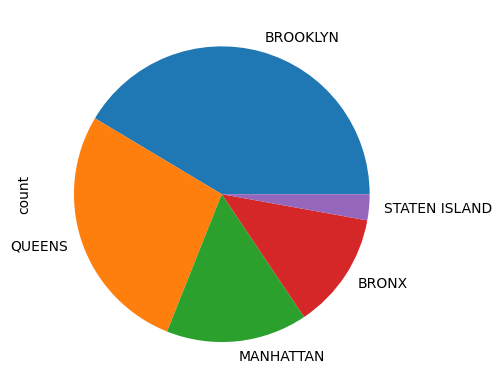

In [51]:
REGISTRATIONS["Boro"].value_counts().plot(kind="pie")

### [Registration Contacts](https://dev.socrata.com/foundry/data.cityofnewyork.us/feu5-w2e2)

In [48]:
REGISTRATIONS_CONTACTS = pd.read_csv(
    "../data/external/Registration_Contacts_20240529.csv"
)

### Pluto

NYC PLUTO (Primary Land Use Tax Lot Output) is a comprehensive dataset provided by the [New York City Department of City Planning](https://www.nyc.gov/site/planning/index.page). It contains detailed information about every tax lot in the city, integrating data from multiple sources such as the Department of Finance, the Department of City Planning, and the Department of Buildings.

In [49]:
PLUTO = pd.read_csv(
    "../data/external/nyc_pluto_24v1_1_csv/pluto_24v1_1.csv",
)

/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/ipykernel_25032/1314918100.py:1: DtypeWarning: Columns (21,22,24,26,28,65,66,88) have mixed types. Specify dtype option on import or set low_memory=False.
  PLUTO = pd.read_csv(


### Violations 

[Housing Maintenance Code Violations](https://dev.socrata.com/foundry/data.cityofnewyork.us/wvxf-dwi5) is the first dataset that we will explore. According to the [metadata](https://dev.socrata.com/foundry/data.cityofnewyork.us/wvxf-dwi5), the dataset contains `9119690` rows (last updated 5/29/2024) containing discrete information for each violation  "against conditions, in rental dwelling units and buildings, that have been verified to violate the New York City Housing Maintenance Code (HMC) or the New York State Multiple Dwelling Law (MDL)".

In [87]:
# VIOLATIONS = dd.read_csv(
#     "../data/external/Housing_Maintenance_Code_Violations.csv",
#     blocksize="512MB",
# )
# VIOLATIONS.to_parquet("../data/interim/VIOLATIONS")
VIOLATIONS = dd.read_parquet("../data/interim/VIOLATIONS").compute()

In [ ]:
VIOLATIONS["hex_id"] = VIOLATIONS.apply(
    lambda row: h3.geo_to_h3(row["Latitude"], row["Longitude"], 7),
    axis=1,
)

## Exploratory Data Analysis

In this step, our primary objective is to familiarize ourselves with the available data sources. Under typical circumstances, we would allocate sufficient time to understand the dataset thoroughly, including its assumptions and limitations. However, due to the time constraints of this assessment, I have opted for a more expedited approach: aggregating the dataset of violations to identify the buildigs with the highest number of reported violations.

### `VIOLATIONS`

Initially, the dataset of violations will be our primary data source. Let's explore its features, but first we calculate the cardinality. In other words, how many violations are represented in this dataset as well as the distribution throughout the boroughs.

In [88]:
len(VIOLATIONS)

9119690

For validation, we note that the [number reported on the catalog](https://dev.socrata.com/foundry/data.cityofnewyork.us/wvxf-dwi5) matches. Now, let's explore some of the features at hand.

In [110]:
VIOLATIONS["ViolationStatus"].value_counts()

ViolationStatus
Close    6398834
Open     2720856
Name: count, dtype: int64[pyarrow]

The majority of violations are not active. However, the historical data may be useful to help idenfying potential recurrent violators.  

In [114]:
plot_vbar(
    VIOLATIONS.groupby(["Borough", "ViolationStatus"])["ViolationID"]
    .nunique()
    .to_dict(),
    title="Housing Maintenance Code Violations by Borough and ViolationStatus",
)

To continue the exploration, we inspect the breakdown the `CurrentStatus` for all violations and open violations,

In [135]:
VIOLATIONS["CurrentStatus"].value_counts()

CurrentStatus
VIOLATION CLOSED                            3912569
VIOLATION DISMISSED                         2422377
NOV SENT OUT                                1627154
FIRST NO ACCESS TO RE- INSPECT VIOLATION     280596
INFO NOV SENT OUT                            222620
NOT COMPLIED WITH                            221111
VIOLATION WILL BE REINSPECTED                 84965
NOTICE OF ISSUANCE SENT TO TENANT             73482
NOV CERTIFIED LATE                            69842
DEFECT LETTER ISSUED                          57148
INVALID CERTIFICATION                         47420
CIV14 MAILED                                  38821
SECOND NO ACCESS TO RE-INSPECT VIOLATION      14772
NOV CERTIFIED ON TIME                         14674
CERTIFICATION POSTPONMENT DENIED              10256
FALSE CERTIFICATION                            9876
CERTIFICATION POSTPONMENT GRANTED              7853
VIOLATION OPEN                                 3036
VIOLATION REOPEN                                49

In [136]:
VIOLATIONS[(VIOLATIONS["ViolationStatus"] == "Open")]["CurrentStatus"].value_counts()

CurrentStatus
NOV SENT OUT                                1627095
FIRST NO ACCESS TO RE- INSPECT VIOLATION     277912
INFO NOV SENT OUT                            222613
NOT COMPLIED WITH                            221004
NOTICE OF ISSUANCE SENT TO TENANT             73481
NOV CERTIFIED LATE                            69771
DEFECT LETTER ISSUED                          57148
INVALID CERTIFICATION                         47418
CIV14 MAILED                                  38819
VIOLATION WILL BE REINSPECTED                 24310
NOV CERTIFIED ON TIME                         14651
SECOND NO ACCESS TO RE-INSPECT VIOLATION      14563
CERTIFICATION POSTPONMENT DENIED              10256
FALSE CERTIFICATION                            9859
CERTIFICATION POSTPONMENT GRANTED              7853
VIOLATION OPEN                                 3023
VIOLATION REOPEN                                497
LEAD DOCS SUBMITTED, NOT ACCEPTABLE             407
LEAD DOCS SUBMITTED, ACCEPTABLE                 13

#### Distribution of violations

We visualize the distribution of Violations by `Borough` and `Class`, 

In [138]:
plot_vbar(
    VIOLATIONS.groupby(["Borough", "Class"])["ViolationID"].nunique().to_dict(),
    title="Housing Maintenance Code Violations by Borough and Class",
)

According to the [documentation](https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5/about_data), Violations are issued in four classes: Class A (non-hazardous), Class B (hazardous), Class C (immediately hazardous) and Class I (information orders). To identify violators, we will look violations for **B** and **C**.

#### Hotstops of Open Violations 

In this step, we identify hotspots of open violations for **Class B (hazardous)**, **Class C (immediately hazardous)**. This criteria should indicate a population most severely impacted by the absolute number of open violations. 

In [143]:
data = (
    VIOLATIONS[
        (VIOLATIONS["ViolationStatus"] == "Open")
        & (VIOLATIONS["hex_id"] != "0")
        & (VIOLATIONS["Class"].isin(["B", "C"]))
    ]
    .groupby(["hex_id"])["ViolationID"]
    .count()
    .to_frame("count")
)

VIOLATIONS_DENSITY = gpd.GeoDataFrame(
    data=data,
    geometry=[Polygon(h3.h3_to_geo_boundary(idx, True)) for idx in data.index],
    crs="EPSG:4326",
)

VIOLATIONS_DENSITY.explore(column="count", cmap="Reds", tiles="CartoDB positron")

### Merging `VIOLATIONS` and `PLUTO`

In this step, we will enrich `VIOLATIONS` with `PLUTO` for additional features about the lot. The `BBL` can be found on both datasets, so it will be used for left merging. First, we will test a straightforward hypothesis: identifying the buildings (via `BuildingID` and the `BBL` (Borough Block Lot)) with the highest number of violations **B** and **C**.

In [162]:
VIOLATIONS_BY_BBL = (
    VIOLATIONS.query('Class == "B" or Class == "C"')
    .groupby(["RegistrationID", "BuildingID", "BBL"])["ViolationID"]
    .nunique()
    .to_frame("violation_count")
    .reset_index()
    .sort_values(["violation_count"])
)

In [163]:
VIOLATIONS_BY_BBL = pd.merge(
    VIOLATIONS_BY_BBL,
    PLUTO,
    left_on=["BBL"],
    right_on=["bbl"],
    how="left",
)



We inspect the number of unique values.

In [164]:
VIOLATIONS[["ViolationID", "Class", "RegistrationID", "BuildingID", "BBL"]].nunique()

ViolationID       9119690
Class                   4
RegistrationID     177667
BuildingID         227468
BBL                214069
dtype: int64

The violations dataset now includes, according to the [Pluto documentation](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/pluto_readme.pdf), (1) Lot Characteristics (2) Building Characteristics and (3) Geographic/Political/Administrative Districts.

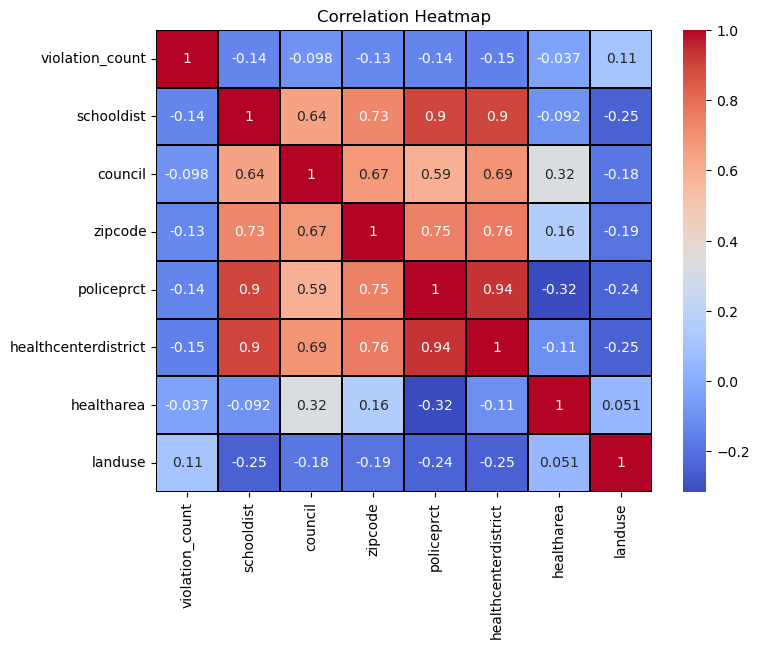

In [195]:
corr = VIOLATIONS_BY_BBL[
    [
        "violation_count",
        "schooldist",
        "council",
        "zipcode",
        "firecomp",
        "policeprct",
        "healthcenterdistrict",
        "healtharea",
        "bldgclass",
        "landuse",
    ]
].corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.1, linecolor="black")
plt.title("Correlation Heatmap")
plt.show()

In principle, the following are the `BBL` with the most reported violations. 

In [198]:
VIOLATIONS_BY_BBL.tail(10)

,RegistrationID,BuildingID,BBL,violation_count,borough,block,lot,cd,bct2020,bctcb2020,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
159225,374352,808252,3.042719e+09,2629,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159226,203983,65392,2.027840e+09,2708,BX,2784.0,10.0,204.0,2022500.0,2.022500e+10,...,NaN,NaN,1.0,NaN,NaN,24v1.1,NaN,40.838367,-73.909677,NaN
159227,203973,806375,2.024310e+09,2747,BX,2431.0,26.0,204.0,2017701.0,2.017701e+10,...,NaN,NaN,1.0,NaN,NaN,24v1.1,NaN,40.833400,-73.910319,NaN
159228,201101,51000,2.037140e+09,2785,BX,3714.0,54.0,209.0,2005001.0,2.005001e+10,...,NaN,NaN,1.0,NaN,NaN,24v1.1,NaN,40.824559,-73.877574,NaN
159229,203139,94506,2.031070e+09,2812,BX,3107.0,36.0,206.0,2036501.0,2.036501e+10,...,NaN,NaN,1.0,NaN,NaN,24v1.1,NaN,40.843845,-73.886827,NaN
159230,201115,77561,2.029500e+09,2816,BX,2950.0,30.0,206.0,2036901.0,2.036901e+10,...,NaN,NaN,1.0,NaN,NaN,24v1.1,NaN,40.844390,-73.891304,NaN
159231,201131,119285,2.024760e+09,2946,BX,2476.0,22.0,204.0,2019500.0,2.019500e+10,...,NaN,NaN,1.0,NaN,NaN,24v1.1,t,40.829758,-73.923101,NaN
159232,207907,65537,2.037840e+09,3208,BX,3784.0,21.0,209.0,2007600.0,2.007600e+10,...,NaN,NaN,1.0,NaN,NaN,24v1.1,NaN,40.832413,-73.868879,NaN
159233,205779,111945,2.037430e+09,3565,BX,3743.0,63.0,209.0,2004800.0,2.004800e+10,...,NaN,NaN,1.0,NaN,NaN,24v1.1,NaN,40.827625,-73.875422,NaN
159234,374310,808705,3.042719e+09,3604,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
CANDIDATES = pd.merge(
    REGISTRATIONS,
    VIOLATIONS_BY_BBL,
    on=["RegistrationID", "BuildingID"],
    how="left",
)

In [201]:
CANDIDATES[
    (CANDIDATES["RegistrationID"] == 374352) & (CANDIDATES["BuildingID"] == 808252)
]

,RegistrationID,BuildingID,BoroID,Boro,HouseNumber,LowHouseNumber,HighHouseNumber,StreetName,StreetCode,Zip,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
188219,374352,808252,3,BROOKLYN,790,790,790,ELDERT LANE,38730,11208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
REGISTRATIONS_CONTACTS[REGISTRATIONS_CONTACTS["RegistrationID"] == 374352]

,RegistrationContactID,RegistrationID,Type,ContactDescription,CorporationName,Title,FirstName,MiddleInitial,LastName,BusinessHouseNumber,BusinessStreetName,BusinessApartment,BusinessCity,BusinessState,BusinessZip
531635,37435203,374352,CorporateOwner,GEN.PART,LINDEN PLAZA PRESERVATION LP,NaN,NaN,NaN,NaN,820,ELMONT ROAD,NaN,ELMONT,NY,11003
531636,37435205,374352,HeadOfficer,GEN.PART,NaN,VICE PRESIDENT,ALAN,NaN,SULLIVAN,820,ELMONT ROAD,NaN,ELMONT,NY,11003
531637,37435206,374352,Officer,GEN.PART,NaN,MANAGING AGENT,ROBERT,NaN,VACCARELLO,1619,THIRD AVENUE,NaN,New York,NY,10128
732794,37435204,374352,Agent,GEN.PART,RY MANAGEMENT CO INC,NaN,CANDICE,NaN,BLAIR,1619,THIRD AVENUE,NaN,New York,NY,10128
738933,37435213,374352,SiteManager,GEN.PART,NaN,NaN,CANDICE,NaN,BLAIR,NaN,NaN,NaN,NaN,NaN,NaN
